In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm

#Plot the amount earned as revenue every month
import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import make_subplots
import colorlover as cl


import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 14
BIGGEST_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [3]:
#Importing all the datasets

train_data = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
# Table on the Date Of Purchase,Shop ID, Item ID, Price and Quantity(Bought Or Returned)
categories_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
# Table on Item Category Name corresponding to the Item Category ID
items_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
# Table Of Name Of the Item along with its ID along with the Item Category ID it is associated with
shops_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
# Table Of Name Of The Shop along with its ID and setting the ID in the file as the ID pandas should use as well
test_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv").set_index('ID')
# Table Of Shop ID along with Item ID for prediction

In [4]:
#dimensions of datasets
print('train:', train_data.shape, 'test:', test_data.shape)
print('items:', items_data.shape, 'item_cats:', categories_data.shape, 'shops:', shops_data.shape)

train: (2935849, 6) test: (214200, 2)
items: (22170, 3) item_cats: (84, 2) shops: (60, 2)


In [5]:
train_data.head()
# date_block_num is a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., 
# October 2015 is 33 and so on

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
(train_data["shop_id"].min(), train_data["shop_id"].max())

(0, 59)

In [7]:
(categories_data["item_category_id"].min(), categories_data["item_category_id"].max())

(0, 83)

In [8]:
test_data.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [9]:
categories_data.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
items_data.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
#To suppress scientific notation in pandas, the below command is executed
pd.options.display.float_format = '{:.5f}'.format

In [13]:
#Explore the price of all items in the training dataset
#For example get max, min, avg and deviation
print(train_data['item_price'].describe())
# NOTE: This includes double calculation for the returned items as well

count   2935849.00000
mean        890.85323
std        1729.79963
min          -1.00000
25%         249.00000
50%         399.00000
75%         999.00000
max      307980.00000
Name: item_price, dtype: float64


In [14]:
#Explore the count of all items in the training dataset
#For example get max, min, avg and deviation
print(train_data['item_cnt_day'].describe())
# NOTE: This is a proper count as returned quantity will appropriately get subracted

count   2935849.00000
mean          1.24264
std           2.61883
min         -22.00000
25%           1.00000
50%           1.00000
75%           1.00000
max        2169.00000
Name: item_cnt_day, dtype: float64


In [15]:
negative_item_price_entries = train_data[train_data['item_price'] < 0]

negative_item_cnt_day_entries = train_data[train_data['item_cnt_day'] < 0]
negative_item_cnt_day_entries = negative_item_cnt_day_entries.reset_index()


negative_item_price_entries

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.00000,1.00000


In [16]:
train_data.loc[(train_data.shop_id==32) & (train_data.item_id==2973) & (train_data.date_block_num==4) & (train_data.item_price > 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.00000,1.00000
484684,06.05.2013,4,32,2973,2499.00000,1.00000


In [17]:
negative_item_cnt_day_entries

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2,05.01.2013,0,25,2552,899.00000,-1.00000
1,148,23.01.2013,0,25,2321,999.00000,-1.00000
2,175,07.01.2013,0,25,2199,1449.00000,-1.00000
3,807,02.01.2013,0,25,2330,599.00000,-1.00000
4,1041,13.01.2013,0,25,5034,1989.00000,-1.00000
...,...,...,...,...,...,...,...
7351,2934243,26.10.2015,33,25,3917,449.00000,-1.00000
7352,2934462,18.10.2015,33,25,4896,6398.00000,-1.00000
7353,2935263,05.10.2015,33,25,10039,249.00000,-1.00000
7354,2935643,16.10.2015,33,25,7893,2990.00000,-1.00000


In [18]:
temp_range = range(len(negative_item_cnt_day_entries))
for i in temp_range:
    # Notify once a set of 100 values have been updated
    if i / 100 == int(i / 100):
        print(i)

    INDEX = negative_item_cnt_day_entries.loc[i, 'index']
    I_ID = negative_item_cnt_day_entries.loc[i, 'item_id']
    ITEM_PRICE = negative_item_cnt_day_entries.loc[i, 'item_price']
    
    possible_item_count = train_data.loc[(train_data.item_id == I_ID) and (train_data.item_price == ITEM_PRICE) and (train_data['item_cnt_day'] > 0)].item_cnt_day.max()
#     print(possible_item_count)
    
    # If no suitable match was found
    if possible_item_count < 0:
        # Try finding a value with a more lenient condition
        possible_item_count = train_data.loc[(train_data.item_id == I_ID) and (train_data['item_cnt_day'] > 0)].item_cnt_day.max()
        
        # If no suitable match is found, then set the value to 1
        if possible_item_count < 0:
            possible_item_count = 1.0
        
    train_data.loc[train_data.index == INDEX, 'item_cnt_day'] = possible_item_count

0


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [19]:
negative_item_cnt_day_entries = train_data[train_data['item_cnt_day'] < 0]
negative_item_cnt_day_entries = negative_item_cnt_day_entries.reset_index()

negative_item_cnt_day_entries.count()

index             7356
date              7356
date_block_num    7356
shop_id           7356
item_id           7356
item_price        7356
item_cnt_day      7356
dtype: int64

In [20]:
negative_item_cnt_day_entries

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2,05.01.2013,0,25,2552,899.00000,-1.00000
1,148,23.01.2013,0,25,2321,999.00000,-1.00000
2,175,07.01.2013,0,25,2199,1449.00000,-1.00000
3,807,02.01.2013,0,25,2330,599.00000,-1.00000
4,1041,13.01.2013,0,25,5034,1989.00000,-1.00000
...,...,...,...,...,...,...,...
7351,2934243,26.10.2015,33,25,3917,449.00000,-1.00000
7352,2934462,18.10.2015,33,25,4896,6398.00000,-1.00000
7353,2935263,05.10.2015,33,25,10039,249.00000,-1.00000
7354,2935643,16.10.2015,33,25,7893,2990.00000,-1.00000


In [21]:
train_data.iloc[2]

date              05.01.2013
date_block_num             0
shop_id                   25
item_id                 2552
item_price         899.00000
item_cnt_day        -1.00000
Name: 2, dtype: object

In [22]:
mean = train_data[(train_data.shop_id==32) & (train_data.item_id==2973) & (train_data.date_block_num==4) & (train_data.item_price > 0)].item_price.mean()
train_data.loc[train_data.item_price < 0, 'item_price'] = mean

train_data.loc[(train_data.shop_id==32) & (train_data.item_id==2973) & (train_data.date_block_num==4) & (train_data.item_price > 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.00000,1.00000
484683,15.05.2013,4,32,2973,1874.00000,1.00000
484684,06.05.2013,4,32,2973,2499.00000,1.00000


In [23]:
#Merging datasets, can be used if required for visualization
train_merged = pd.merge(train_data, items_data, on='item_id', how='inner')
train_merged = pd.merge(train_merged, categories_data, on='item_category_id', how='inner')
train_merged = pd.merge(train_merged, shops_data, on='shop_id', how='inner')
# Inner join selects only those rows from both the tables which satisfy the join condition of ID

In [24]:
#Snippet of merged dataset
train_merged.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00000,1.00000,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.00000,1.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.50000,1.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.50000,1.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.00000,2.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [25]:
#Extract and add some more features

train_merged['total_sales'] = train_merged.item_price * train_merged.item_cnt_day
train_merged['date'] = pd.to_datetime(train_merged.date)
train_merged['Month'] = train_merged['date'].dt.month
train_merged['Year'] = train_merged['date'].dt.year
train_merged['day_of_week'] = train_merged['date'].dt.day_name()

In [26]:
#snippet of train_merged
print(train_merged.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-02-01               0       59    22154   999.00000       1.00000   
1 2013-04-26               3       59      944   150.00000       1.00000   
2 2013-06-26               5       59      944   199.50000       1.00000   
3 2013-07-20               6       59      944   199.50000       1.00000   
4 2013-09-14               8       59      944   299.00000       2.00000   

           item_name  item_category_id item_category_name  \
0  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray   
1          2012 (BD)                37     Кино - Blu-Ray   
2          2012 (BD)                37     Кино - Blu-Ray   
3          2012 (BD)                37     Кино - Blu-Ray   
4          2012 (BD)                37     Кино - Blu-Ray   

                shop_name  total_sales  Month  Year day_of_week  
0  Ярославль ТЦ "Альтаир"    999.00000      2  2013      Friday  
1  Ярославль ТЦ "Альтаир"    150.00000      

In [27]:
#drop entries with negative item count
train_merged=train_merged[train_merged.item_cnt_day>=0]

In [28]:
chosen_colors=cl.scales['5']['qual']['Paired']
ply.init_notebook_mode(connected=True)
temp_df = train_merged.groupby('date_block_num')[['total_sales']].sum().reset_index()
temp_df.astype('float')

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df.date_block_num, y=temp_df.total_sales,
                    mode='lines',
                    line= dict(color='green', width=2)))

fig.update_layout(title='Monthly Revenue',
                   xaxis_title='Month',
                   yaxis_title='Total sales')

fig.show()

In [29]:
temp_df2 = train_merged.groupby('date_block_num')[['item_cnt_day']].sum().reset_index()
temp_df2.astype('float')

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df2.date_block_num, y=temp_df2.item_cnt_day,
                    mode='lines',
                    line= dict(color='green', width=2)))

fig.update_layout(title='Monthly Item Count',
                   xaxis_title='Month',
                   yaxis_title='Item Count')

fig.show()

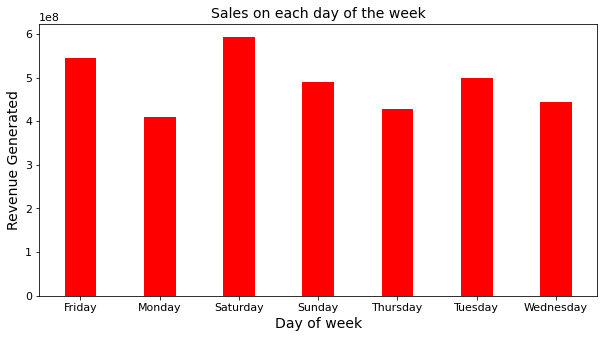

In [30]:
temp_df3 = train_merged.groupby('day_of_week')[['total_sales']].sum().reset_index()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot 
plt.bar(temp_df3['day_of_week'], temp_df3['total_sales'], color ='red',  
        width = 0.4) 
  
plt.xlabel("Day of week") 
plt.ylabel("Revenue Generated") 
plt.title("Sales on each day of the week") 
plt.show()
#Friday, Saturday, Sunday highest in terms of sales

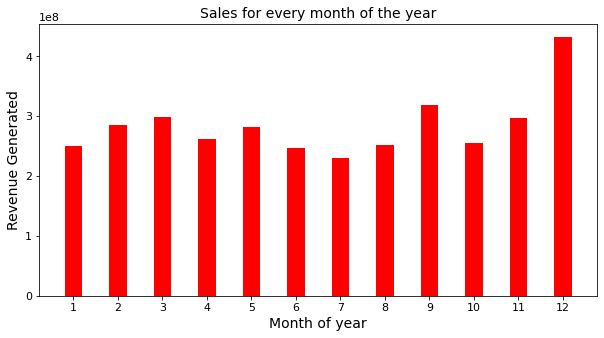

In [31]:
temp_df4 = train_merged.groupby('Month')[['total_sales']].sum().reset_index()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot 
plt.bar(temp_df4['Month'], temp_df4['total_sales'], color ='red',  
        width = 0.4) 
  
plt.xlabel("Month of year") 
plt.ylabel("Revenue Generated") 
plt.title("Sales for every month of the year") 
plt.xticks([i for i in range(1, 13)])
plt.show()
#Most sales during december festive season

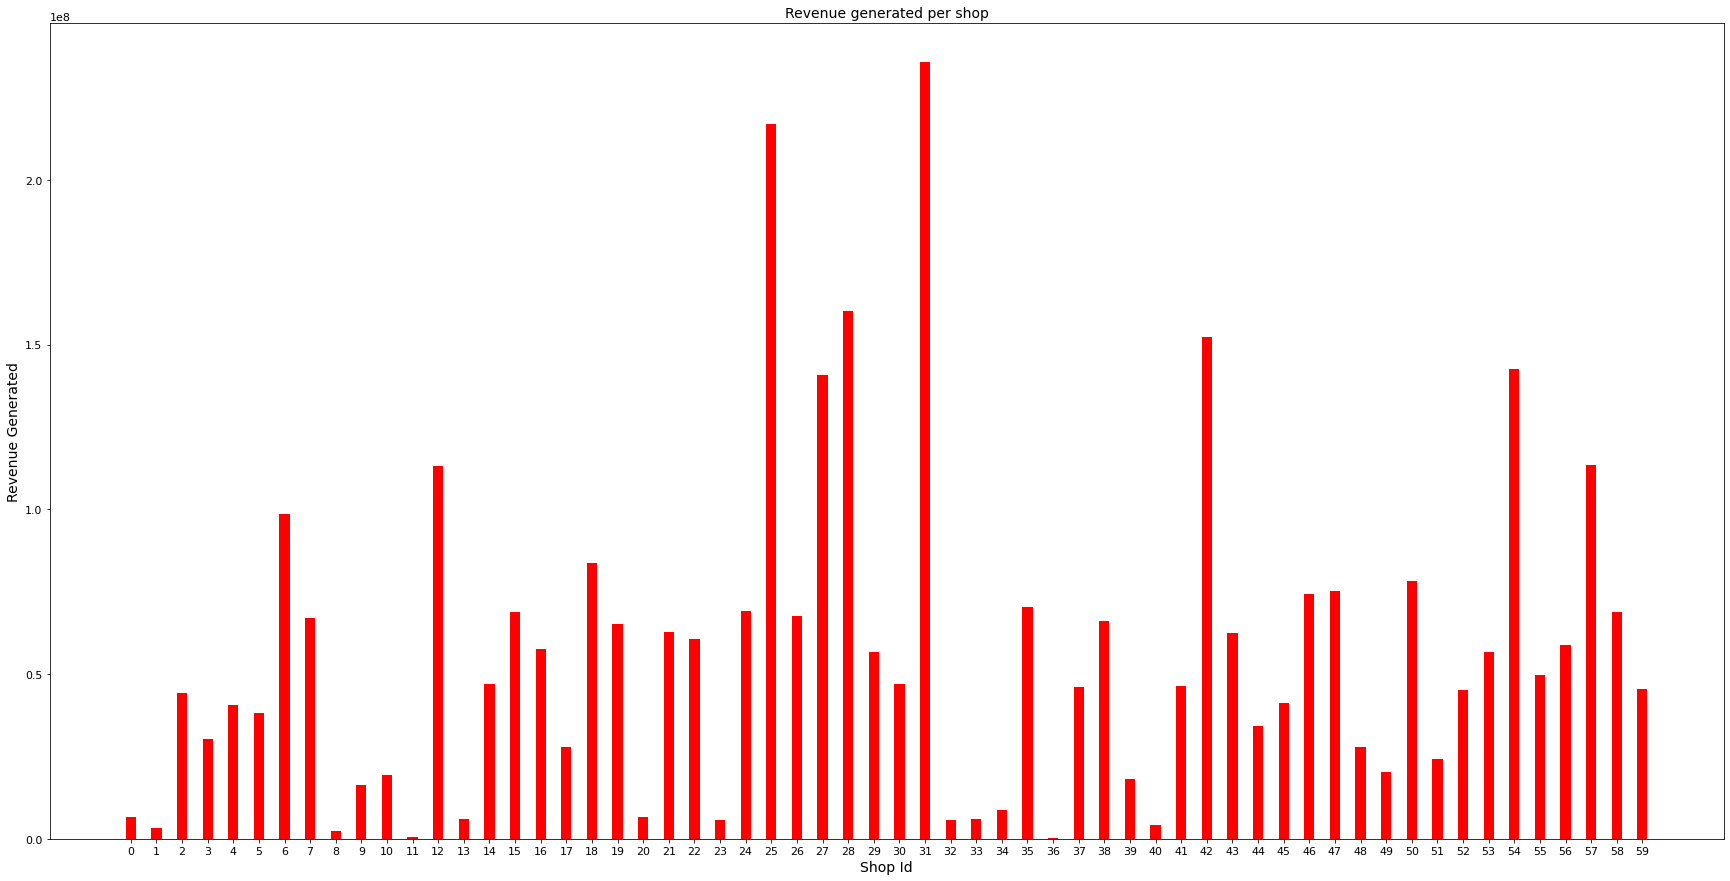

In [32]:
temp_df5 = train_merged.groupby('shop_id')[['total_sales']].sum().reset_index()
fig = plt.figure(figsize = (30, 15))

# creating the bar plot 
plt.bar(temp_df5['shop_id'], temp_df5['total_sales'], color ='red',  
        width = 0.4) 
  
plt.xlabel("Shop Id") 
plt.ylabel("Revenue Generated") 
plt.title("Revenue generated per shop") 
plt.xticks([i for i in range(60)])
plt.show()
#Most sales during december festive season

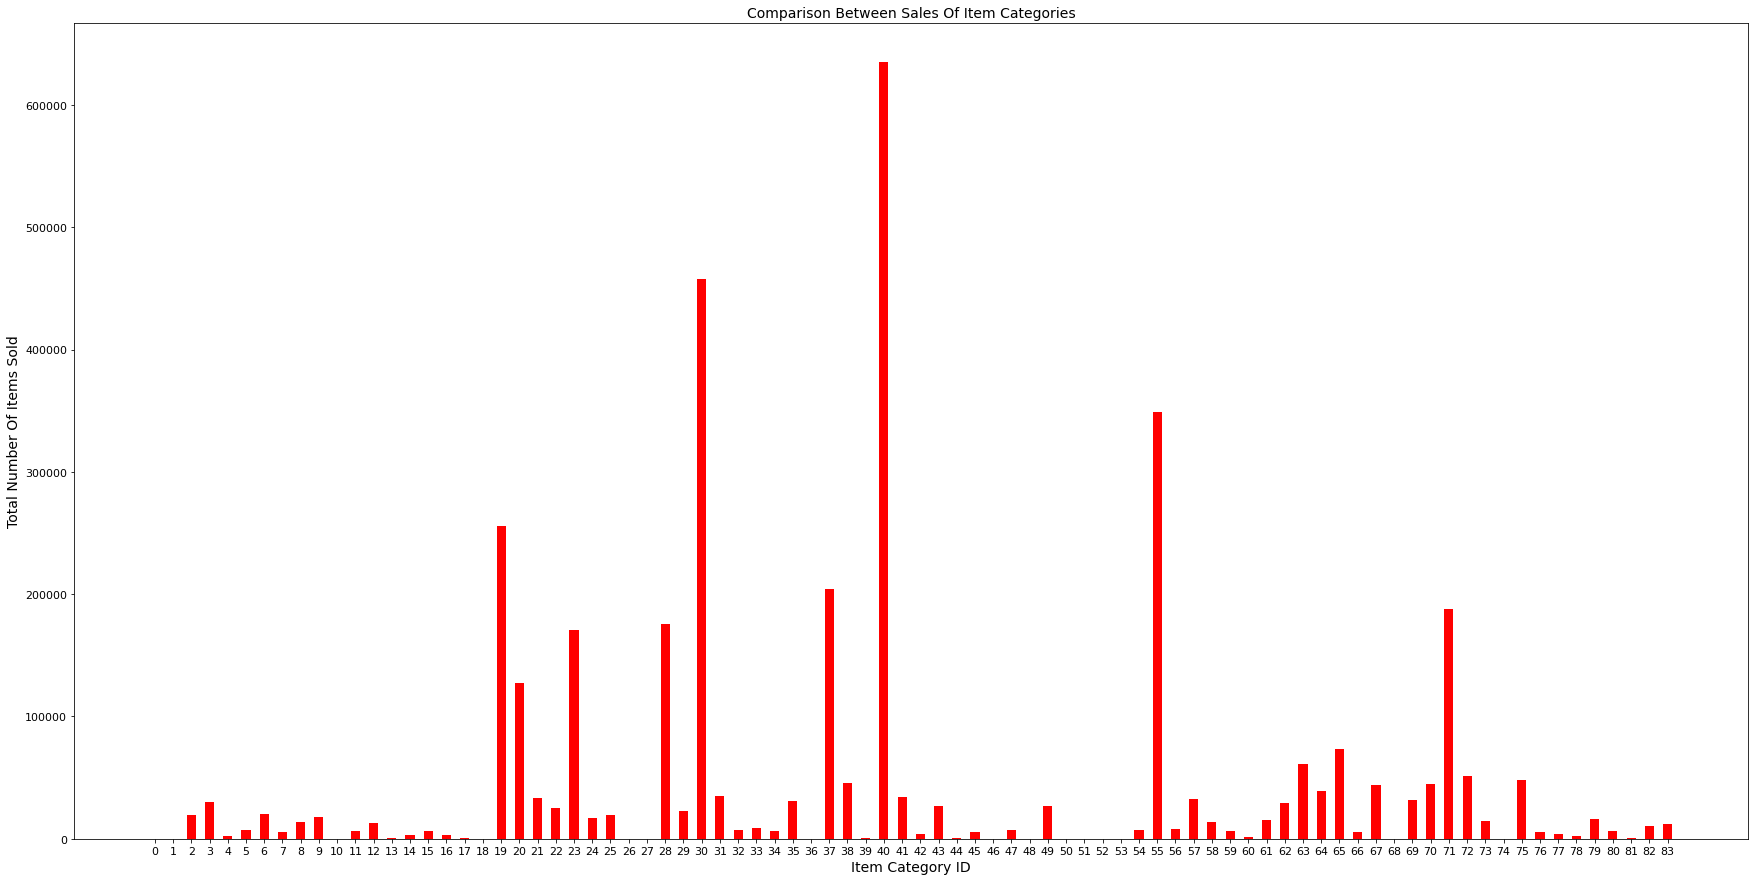

In [33]:
temp_df6 = train_merged.groupby('item_category_id')[['item_cnt_day']].sum().reset_index()
fig = plt.figure(figsize=(30,15))

plt.bar(temp_df6['item_category_id'],temp_df6['item_cnt_day'], color='red',width=0.5)

plt.xlabel("Item Category ID")
plt.ylabel("Total Number Of Items Sold")
plt.title("Comparison Between Sales Of Item Categories")
plt.xticks([i for i in range(84)])
plt.show()
# Maximum Sales in Item Category 40, followed by 30 and then 55

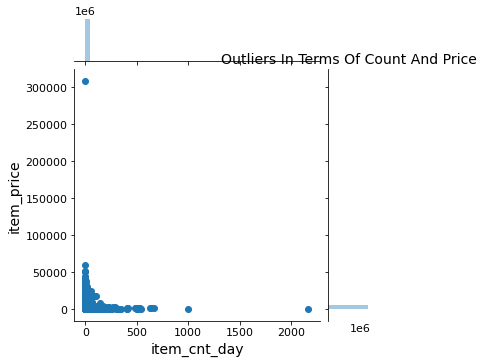

In [34]:
sns.jointplot(x="item_cnt_day", y="item_price", data=train_merged, height=5)
plt.title("Outliers In Terms Of Count And Price")
plt.show()
# Thus outliers are price greater than 50,000 and count greater than 500 and can cause significant
# amount of noise in the computation for prediction

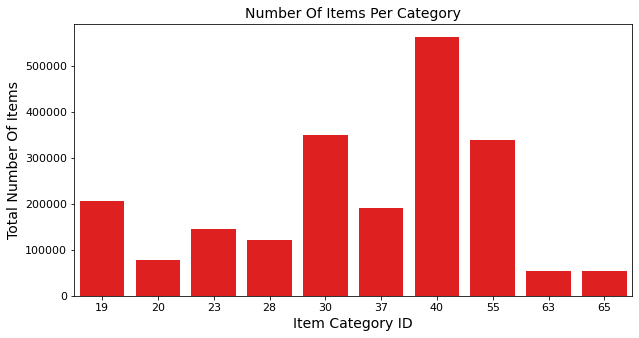

In [35]:
x=train_merged.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False) # Sort In Descending Order Of The Number Of Items 
x=x.iloc[0:10].reset_index() # Select The Top 10 for the graph

plt.figure(figsize=(10,5))
y= sns.barplot(x.item_category_id, x.item_id, color='red')
plt.title("Number Of Items Per Category")
plt.ylabel('Total Number Of Items')
plt.xlabel('Item Category ID')
plt.show()
#Thus total number of sales that were high for item_categories 40,30 and 55 were due to proportionately
# high number of items in those categories

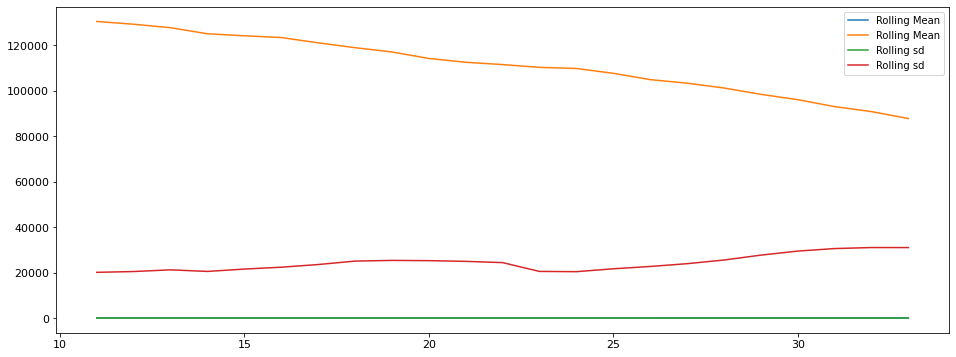

In [36]:
plt.figure(figsize=(16,6))
plt.plot(temp_df2.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(temp_df2.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

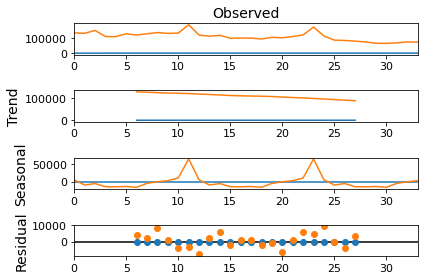

In [37]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(temp_df2.values,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [38]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00000,1.00000
1,03.01.2013,0,25,2552,899.00000,1.00000
2,05.01.2013,0,25,2552,899.00000,-1.00000
3,06.01.2013,0,25,2554,1709.05000,1.00000
4,15.01.2013,0,25,2555,1099.00000,1.00000


In [39]:
#Drop entries with negative Item_cnt_day
train_data=train_data[train_data['item_cnt_day']>0]

In [40]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00000,1.00000
1,03.01.2013,0,25,2552,899.00000,1.00000
3,06.01.2013,0,25,2554,1709.05000,1.00000
4,15.01.2013,0,25,2555,1099.00000,1.00000
5,10.01.2013,0,25,2564,349.00000,1.00000


In [41]:
train_final= train_data.join(items_data, on='item_id',rsuffix='_')
train_final = train_final.join(shops_data, on='shop_id', rsuffix='_')
train_final = train_final.join(categories_data, on='item_category_id', rsuffix='_')

In [42]:
#Since dataset consumes large amount of data, we reduce size of some datatypes by downcasting
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train_final = downcast_dtypes(train_final)
print(train_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928493 entries, 0 to 2935848
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int16  
 2   shop_id             int16  
 3   item_id             int16  
 4   item_price          float32
 5   item_cnt_day        float32
 6   item_name           object 
 7   item_id_            int16  
 8   item_category_id    int16  
 9   shop_name           object 
 10  shop_id_            int16  
 11  item_category_name  object 
 12  item_category_id_   int16  
dtypes: float32(2), int16(7), object(4)
memory usage: 173.2+ MB
None


In [43]:
test_shop_ids = test_data['shop_id'].unique()
test_item_ids = test_data['item_id'].unique()
# Only shops that exist in test set.
leak_df = train_final[train_final['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
leak_df = leak_df[leak_df['item_id'].isin(test_item_ids)]
print('Data set size before leaking:', train_final.shape[0])
print('Data set size after leaking:', leak_df.shape[0])
train_final = leak_df

Data set size before leaking: 2928493
Data set size after leaking: 1221498


In [44]:
#Drop these string based columns, that are not required for training purposes
train_final.drop(['item_name','shop_name','item_category_name','item_category_id'],axis=1,inplace=True)

In [45]:
train_final.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_id_,shop_id_,item_category_id_
0,02.01.2013,0,59,22154,999.00000,1.00000,22154,59,37
10,03.01.2013,0,25,2574,399.00000,2.00000,2574,25,55
11,05.01.2013,0,25,2574,399.00000,1.00000,2574,25,55
12,07.01.2013,0,25,2574,399.00000,1.00000,2574,25,55
13,08.01.2013,0,25,2574,399.00000,2.00000,2574,25,55


In [46]:
#shop_id_ and shop_id are the same so we drop one of them
#item_id_ and item_id are the same so we drop one of them
train_final.drop(['shop_id_','item_id_'],axis=1,inplace=True)

In [47]:
train_final.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id_
0,02.01.2013,0,59,22154,999.00000,1.00000,37
10,03.01.2013,0,25,2574,399.00000,2.00000,55
11,05.01.2013,0,25,2574,399.00000,1.00000,55
12,07.01.2013,0,25,2574,399.00000,1.00000,55
13,08.01.2013,0,25,2574,399.00000,2.00000,55


In [48]:
#Drop rows where item price is less than zero
train_final=train_final[train_final['item_price']>0]

In [49]:
#We group the data by the month block number, shop_id and item_id, so that predictions can be made based on that
train_final = train_final.sort_values('date').groupby(['date_block_num', 'shop_id','item_id'], as_index=False)
#getting aggregates as extra columns
train_final = train_final.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_final.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mitem_price', 'item_cnt', 'mitem_cnt', 'transactions']

In [50]:
train_final['year'] = train_final['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_final['month'] = train_final['date_block_num'].apply(lambda x: (x % 12))

In [51]:
#Keep only the data that satisfies the condition as the rest are outliers
train_final = train_final.query('item_cnt >= 0 and item_cnt <= 1500 and item_price < 400000')

In [52]:
train_final['cnt_m'] = train_final.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt'].shift(-1)

In [53]:
train_final.head()

,date_block_num,shop_id,item_id,item_price,mitem_price,item_cnt,mitem_cnt,transactions,year,month,cnt_m
0,0,2,33,499.00000,499.00000,1.00000,1.00000,1,2013,0,2.00000
1,0,2,482,3300.00000,3300.00000,1.00000,1.00000,1,2013,0,1.00000
2,0,2,491,600.00000,600.00000,1.00000,1.00000,1,2013,0,1.00000
3,0,2,839,3300.00000,3300.00000,1.00000,1.00000,1,2013,0,1.00000
4,0,2,1007,1347.00000,449.00000,3.00000,1.00000,3,2013,0,1.00000


In [54]:
#We need to have all combinations of date_block_num,shop_id,item_id
#So we add the ones that are not already present
#Then we fill them up with zeros
import time
ts = time.time()
shop_ids = train_final['shop_id'].unique()
item_ids = train_final['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
print(time.time()-ts)

21.755233764648438


In [55]:
train_final = pd.merge(empty_df, train_final, on=['date_block_num','shop_id','item_id'], how='left')
train_final.fillna(0, inplace=True)

In [56]:
#Split the dataset into train, test and validation sets
#date block no.s 0 to 25 -> train set
#date block no.s 26 to 32 -> validation set
#date block no 33 -> test set
train_set = train_final.query('date_block_num >= 0 and date_block_num < 26').copy()
validation_set = train_final.query('date_block_num >= 26 and date_block_num < 33').copy()
test_set = train_final.query('date_block_num == 33').copy()

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Percent of train_set:',(train_set.shape[0]/train_final.shape[0])*100,'%')
print('Percent of validation_set:',(validation_set.shape[0]/train_final.shape[0])*100,'%')
print('Percent of test_set:',(test_set.shape[0]/train_final.shape[0])*100,'%')

Train set records: 5149872
Validation set records: 1386504
Test set records: 198072
Percent of train_set: 76.47058823529412 %
Percent of validation_set: 20.588235294117645 %
Percent of test_set: 2.941176470588235 %


In [57]:
#dropping NA
train_set.dropna(subset=['cnt_m'], inplace=True)
validation_set.dropna(subset=['cnt_m'], inplace=True)

In [58]:
# Creating training set
x_train = train_set.drop(['cnt_m','date_block_num'],axis=1)
y_train = train_set['cnt_m'].astype(int)

#Creating validation set
x_val = validation_set.drop(['cnt_m','date_block_num'],axis=1)
y_val = validation_set['cnt_m'].astype(int)

In [59]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
x_test = pd.merge(test_data, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
x_test['year'] = 2015
x_test['month'] = 9
x_test.drop('cnt_m', axis=1, inplace=True)
x_test = x_test[x_train.columns]

In [60]:

sets = [x_train, x_val, x_test]
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median

In [61]:
#Fill the remaining missing values in test set with the mean
x_test.fillna(x_test.mean(), inplace=True)

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [63]:
#base model is m1->Linear Regression
#Another model is m2->Random Forest Regression
m1 = LinearRegression()
m2 = RandomForestRegressor(n_estimators=10)

In [64]:
m1.fit(x_train,y_train)

LinearRegression()

In [65]:
m2.fit(x_train,y_train)

RandomForestRegressor(n_estimators=10)

In [66]:
train_pred1=m1.predict(x_train)
train_pred2=m2.predict(x_train)

In [67]:
from sklearn.metrics import mean_squared_error
print('Linear Regression RMSE error on training set:',np.sqrt(mean_squared_error(y_train, train_pred1)))
print('Random Forest Regression RMSE error on training set:',np.sqrt(mean_squared_error(y_train, train_pred2)))

Linear Regression RMSE error on training set: 1.7199570838681204
Random Forest Regression RMSE error on training set: 0.6357835102394742


In [68]:
val_pred1=m1.predict(x_val)
val_pred2=m2.predict(x_val)

In [69]:
print('Linear Regression RMSE error on validation set:',np.sqrt(mean_squared_error(y_val, val_pred1)))
print('Random Forest Regression RMSE error on validation set:',np.sqrt(mean_squared_error(y_val, val_pred2)))

Linear Regression RMSE error on validation set: 1.6969401682988619
Random Forest Regression RMSE error on validation set: 1.4216734539186175


In [70]:
#predictions on test set
test_pred1=m1.predict(x_test)
test_pred2=m2.predict(x_test)

In [71]:
from xgboost import XGBRegressor
from xgboost import plot_importance

model = XGBRegressor(max_depth=8,min_child_weight=300,n_estimators=10,eta=0.3)
model.fit(x_train,y_train)
#1)max_depth is for the depth of the tree. Increasing this value will make the model more complex and more likely to overfit
#2)min_child_weight is the minimum sum of instance weight needed in a child. If the tree partition step results in a leaf node with the 
#sum of instance weight less than min_child_weight, then the building process will give up further partitioning
#4) eta is nothing but default learning rate
train_xgb_pred=model.predict(x_train)
print('XGBoost RMSE error on training set:',np.sqrt(mean_squared_error(y_train, train_xgb_pred)))

[15:01:19] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
XGBoost RMSE error on training set: 2.2246722594417996


In [72]:
val_xgb_pred=model.predict(x_val)
print('XGBoost RMSE error on validation set:',np.sqrt(mean_squared_error(y_val, val_xgb_pred)))

XGBoost RMSE error on validation set: 1.5324831705610868


In [73]:
#predictions on test set
test_xgb_pred=model.predict(x_test)